In [4]:
!pip install dimod
!pip install dwave.system
!pip install pulp
!pip install matplotlib
!pip install networkX

In [5]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 45.1 MB/s eta 0:00:00


Solving with PuLP (using default CBC solver)...
selected_edges: [((0, 0), (1, 1)), ((1, 1), (2, 2)), ((2, 2), (3, 3)), ((3, 3), (4, 4)), ((4, 4), (5, 4)), ((5, 4), (6, 4)), ((6, 4), (7, 5)), ((7, 5), (7, 6)), ((7, 6), (7, 7)), ((7, 7), (8, 8)), ((8, 8), (9, 9))]
Total Path Weight using PuLP: 13.90
Shortest Path Found:
Edge: ((0, 0), (1, 0))
Edge: ((1, 0), (2, 0))
Edge: ((2, 0), (3, 0))
Edge: ((3, 0), (4, 0))
Edge: ((4, 0), (5, 0))
Edge: ((5, 0), (5, 1))
Edge: ((5, 1), (5, 2))
Edge: ((5, 2), (5, 3))
Edge: ((5, 3), (5, 4))
Edge: ((5, 4), (6, 4))
Edge: ((6, 4), (7, 4))
Edge: ((7, 4), (7, 5))
Edge: ((7, 5), (7, 6))
Edge: ((7, 6), (8, 6))
Edge: ((8, 6), (9, 6))
Edge: ((9, 6), (9, 7))
Edge: ((9, 7), (9, 8))
Edge: ((9, 8), (9, 9))
Total Weight of Path using NetworkX: 18.00


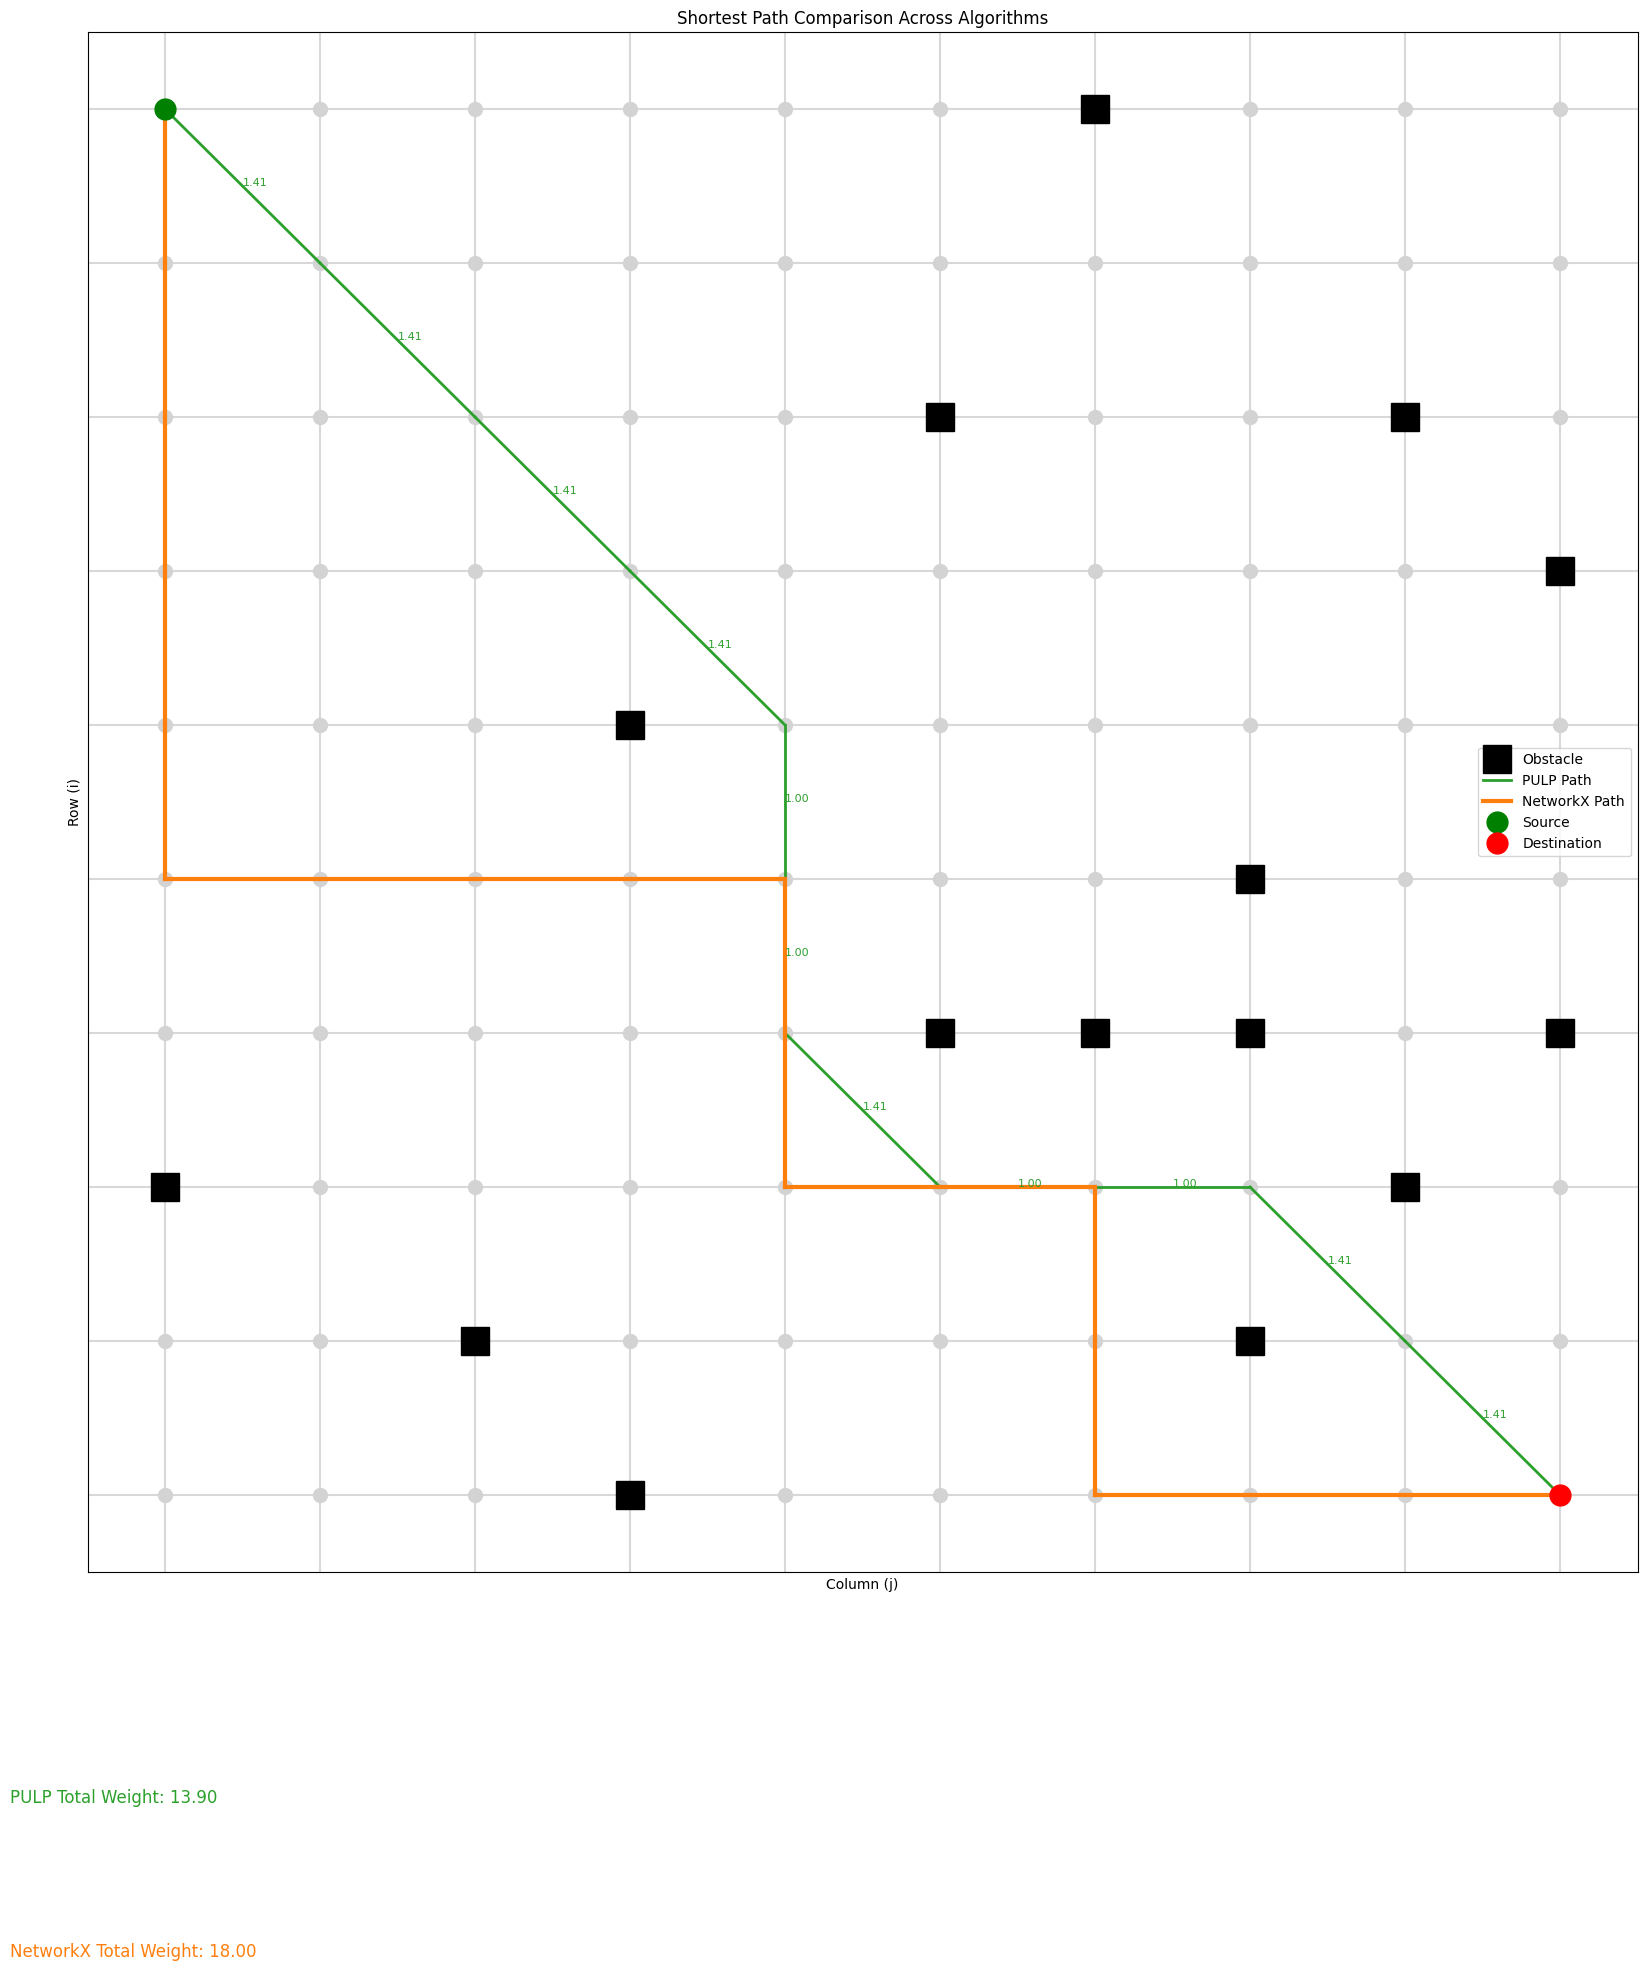

In [7]:
# import dimod
# from dwave.system import LeapHybridCQMSampler
import matplotlib.pyplot as plt
import random
import pulp
import networkx as nx
import math

# UNCOMMENT THE SECTION BELOW WHEN YOU HAVE DWAVE ACCESS
"""
def create_cqm_shortest_path(grid_size=5, diagonal_weight=1.414,source=None,destination=None,obstacles=None):
    if obstacles is None:
        obstacles = set()

    # Create the CQM model
    cqm = dimod.ConstrainedQuadraticModel()

    # Grid coordinates
    coordinates = [(i, j) for i in range(grid_size) for j in range(grid_size)]

    # # Source and destination
    # source = (1, 2)
    # destination = (9, 2)

    # Create node variables (excluding source, destination, and obstacles)
    nodes = {
        (i, j): dimod.Binary(f"node_{i}_{j}")
        for i, j in coordinates
        if (i, j) != source and (i, j) != destination and (i, j) not in obstacles
    }

    def is_diagonal(pos1, pos2):
        # Check if the edge is diagonal
        return abs(pos1[0] - pos2[0]) == 1 and abs(pos1[1] - pos2[1]) == 1

    def get_neighbors(i, j):
        neighbors = []
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni, nj = i + di, j + dj
                if 0 <= ni < grid_size and 0 <= nj < grid_size and (ni, nj) not in obstacles:
                    neighbors.append((ni, nj))
        return neighbors

    # Create edge variables with weights
    edges = {}
    edge_weights = {}
    for i, j in coordinates:
        if (i, j) in obstacles:
            continue
        for ni, nj in get_neighbors(i, j):
            if (i, j) < (ni, nj):  # Avoid duplicate edges
                edges[((i, j), (ni, nj))] = dimod.Binary(f"edge_{i}_{j}_{ni}_{nj}")
                # Assign weight based on whether it's diagonal
                weight = diagonal_weight if is_diagonal((i, j), (ni, nj)) else 1.0
                edge_weights[((i, j), (ni, nj))] = weight

    # Objective: Minimize total weighted path length
    objective = dimod.quicksum(edge_weights[edge] * edges[edge] for edge in edges)
    cqm.set_objective(objective)

    # Constraint 1: Source must have exactly one outgoing edge
    source_edges = []
    for ni, nj in get_neighbors(source[0], source[1]):
        if ((source[0], source[1]), (ni, nj)) in edges:
            source_edges.append(edges[((source[0], source[1]), (ni, nj))])
    cqm.add_constraint(dimod.quicksum(source_edges) == 1, label="Source Constraint")

    # Constraint 2: Destination must have exactly one incoming edge
    dest_edges = []
    for ni, nj in get_neighbors(destination[0], destination[1]):
        if ((ni, nj), (destination[0], destination[1])) in edges:
            dest_edges.append(edges[((ni, nj), (destination[0], destination[1]))])
    cqm.add_constraint(dimod.quicksum(dest_edges) == 1, label="Destination Constraint")

    # Constraint 3: Flow conservation for intermediate nodes
    for i, j in coordinates:
        if (i, j) != source and (i, j) != destination and (i, j) not in obstacles:
            node_edges_in = []
            node_edges_out = []
            for ni, nj in get_neighbors(i, j):
                if ((i, j), (ni, nj)) in edges:
                    node_edges_out.append(edges[((i, j), (ni, nj))])
                if ((ni, nj), (i, j)) in edges:
                    node_edges_in.append(edges[((ni, nj), (i, j))])

            cqm.add_constraint(
                dimod.quicksum(node_edges_out) - dimod.quicksum(node_edges_in) == 0,
                label=f"Flow Conservation at ({i}, {j})"
            )

    return cqm, edges, edge_weights, source, destination
"""


def create_pulp_shortest_path(grid_size=5, diagonal_weight=1.414, source=None, destination=None, obstacles=None):
    if obstacles is None:
        obstacles = set()

    # Problem definition
    prob = pulp.LpProblem("Shortest_Path", pulp.LpMinimize)

    # Grid coordinates
    coordinates = [(i, j) for i in range(grid_size) for j in range(grid_size)]

    # Variables: Create edge variables
    edges = {}
    edge_weights = {}
    for i, j in coordinates:
        if (i, j) in obstacles:
            continue
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < grid_size and 0 <= nj < grid_size and (ni, nj) not in obstacles:
                if (i, j) < (ni, nj):  # Avoid duplicate edges
                    edge_var = pulp.LpVariable(f"edge_{i}_{j}_{ni}_{nj}", cat="Binary")
                    edges[((i, j), (ni, nj))] = edge_var
                    weight = diagonal_weight if abs(di) == 1 and abs(dj) == 1 else 1.0
                    edge_weights[((i, j), (ni, nj))] = weight

    # Objective: Minimize total weighted path length
    prob += pulp.lpSum(edge_weights[edge] * edges[edge] for edge in edges), "Minimize_Weight"

    # Constraint 1: Source must have exactly one outgoing edge
    prob += (
        pulp.lpSum(edges[((source[0], source[1]), (ni, nj))]
                   for ni, nj in [(source[0] + di, source[1] + dj)
                                  for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]]
                   if ((source[0], source[1]), (ni, nj)) in edges) == 1,
        "Source_Constraint"
    )

    # Constraint 2: Destination must have exactly one incoming edge
    prob += (
        pulp.lpSum(edges[((ni, nj), (destination[0], destination[1]))]
                   for ni, nj in [(destination[0] + di, destination[1] + dj)
                                  for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]]
                   if ((ni, nj), (destination[0], destination[1])) in edges) == 1,
        "Destination_Constraint"
    )

    # Constraint 3: Flow conservation for intermediate nodes
    for i, j in coordinates:
        if (i, j) != source and (i, j) != destination and (i, j) not in obstacles:
            prob += (
                pulp.lpSum(edges[((i, j), (ni, nj))]
                           for ni, nj in [(i + di, j + dj)
                                          for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]]
                           if ((i, j), (ni, nj)) in edges) -
                pulp.lpSum(edges[((ni, nj), (i, j))]
                           for ni, nj in [(i + di, j + dj)
                                          for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]]
                           if ((ni, nj), (i, j)) in edges) == 0,
                f"Flow_Conservation_{i}_{j}"
            )

    return prob, edges, edge_weights



def create_grid_graph(grid_size, diagonal_move=True, obstacles=None):
    """
    Create a graph representation of the grid

    Args:
        grid_size (int): Size of the grid
        diagonal_move (bool): Allow diagonal moves
        obstacles (set): Set of (x,y) coordinates to block

    Returns:
        networkx.Graph: Graph representation of the grid
    """
    # Create graph
    G = nx.grid_2d_graph(grid_size, grid_size)

    # Remove obstacles
    if obstacles:
        for obs in list(obstacles):
            if obs in G:
                G.remove_node(obs)

    # Add weights to edges
    for (u, v, d) in G.edges(data=True):
        # Calculate edge weight
        if abs(u[0] - v[0]) + abs(u[1] - v[1]) > 1:  # Diagonal move
            d['weight'] = math.sqrt(2)  # Diagonal distance
        else:
            d['weight'] = 1.0  # Orthogonal move

    return G

def solve_shortest_path(grid_size, start, end, obstacles=None, diagonal_move=True):
    """
    Solve shortest path problem using NetworkX

    Args:
        grid_size (int): Size of the grid
        start (tuple): Starting coordinates
        end (tuple): Ending coordinates
        obstacles (set): Set of (x,y) coordinates to block
        diagonal_move (bool): Allow diagonal moves

    Returns:
        tuple: Shortest path edges and total weight
    """
    # Create graph
    G = create_grid_graph(grid_size, diagonal_move, obstacles)

    # Ensure start and end are in the graph
    if start not in G or end not in G:
        raise ValueError("Start or end point is not in the graph")

    try:
        # Use Dijkstra's algorithm for shortest path
        path = nx.shortest_path(G, start, end, weight='weight')
        total_weight = nx.shortest_path_length(G, start, end, weight='weight')

        # Convert path to edges
        path_edges = list(zip(path[:-1], path[1:]))

        return path_edges, total_weight

    except nx.NetworkXNoPath:
        raise ValueError(f"No path exists between {start} and {end}")



def generate_random_obstacles(grid_size, num_obstacles=50):
    """Generate random obstacles on the grid"""
    obstacles = set()
    while len(obstacles) < num_obstacles:
        i, j = random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        if (i, j) != (0, 0) and (i, j) != (grid_size-1, grid_size-1):  # Avoid start and destination points
            obstacles.add((i, j))
    return obstacles

# visualize_path(grid_size, paths, source, destination, edge_weights, obstacles=obstacles)
def visualize_path(grid_size, paths, path, source, destination, edge_weights, obstacles=None):
    """
    Visualizes the grid and paths from multiple algorithms.

    Args:
        grid_size (int): Size of the grid.
        paths (dict): Dictionary with keys as algorithm names and values as selected edges.
        path (tuple): Contains path details specific to NetworkX.
        source (tuple): Source node.
        destination (tuple): Destination node.
        edge_weights (dict): Dictionary of edge weights.
        obstacles (set): Set of obstacle nodes.
    """
    if obstacles is None:
        obstacles = set()

    plt.figure(figsize=(20, 20))

    # Draw grid
    for i in range(grid_size):
        plt.axhline(y=i, color='gray', linestyle='-', alpha=0.3)
        plt.axvline(x=i, color='gray', linestyle='-', alpha=0.3)

    # Draw all nodes
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in obstacles:
                plt.plot(j, grid_size-1-i, 's', color='black', markersize=20,
                         label='Obstacle' if 'Obstacle' not in plt.gca().get_legend_handles_labels()[1] else "")
            else:
                plt.plot(j, grid_size-1-i, 'o', color='lightgray', markersize=10)

    # Define contrast colors for algorithms
    colors = {
        "CQM": '#1f77b4',       # Blue
        "PULP": '#2ca02c',      # Green
        "NetworkX": '#ff7f0e'   # Orange
    }
    labels_drawn = set()  # To track which labels have been added to the legend

    # Draw paths for each algorithm
    for algo, edges in paths.items():
        total_weight = 0

        if algo == "NetworkX":
            # Draw path for NetworkX
            full_path = [source] + [v for _, v in path[0]] + [destination]
            for (u, v) in zip(full_path[:-1], full_path[1:]):
                if algo not in labels_drawn:
                    plt.plot([u[1], v[1]], [grid_size-1-u[0], grid_size-1-v[0]],
                             label=f'{algo} Path', linewidth=3, color=colors[algo])
                    labels_drawn.add(algo)
                else:
                    plt.plot([u[1], v[1]], [grid_size-1-u[0], grid_size-1-v[0]],
                             linewidth=3, color=colors[algo])
            # Calculate total weight for NetworkX
            total_weight = sum(edge_weights[edge] for edge in path[0])
        else:
            # Draw path for other algorithms
            for edge in edges:
                (i1, j1), (i2, j2) = edge
                weight = edge_weights[edge]
                total_weight += weight
                if algo not in labels_drawn:
                    plt.plot([j1, j2], [grid_size-1-i1, grid_size-1-i2],
                             linewidth=2, label=f'{algo} Path', color=colors[algo])
                    labels_drawn.add(algo)
                else:
                    plt.plot([j1, j2], [grid_size-1-i1, grid_size-1-i2],
                             linewidth=2, color=colors[algo])

                # Add weight label
                mid_x = (j1 + j2) / 2
                mid_y = (grid_size-1-i1 + grid_size-1-i2) / 2
                plt.text(mid_x, mid_y, f'{weight:.2f}', color=colors[algo], fontsize=8)

        # Display total weight at the bottom-left corner
        plt.text(-1, -2 - list(paths.keys()).index(algo),
                 f'{algo} Total Weight: {total_weight:.2f}', color=colors[algo], fontsize=12)

    # Highlight source and destination
    plt.plot(source[1], grid_size-1-source[0], 'go', markersize=15, label='Source' if 'Source' not in labels_drawn else "")
    plt.plot(destination[1], grid_size-1-destination[0], 'ro', markersize=15, label='Destination' if 'Destination' not in labels_drawn else "")

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title('Shortest Path Comparison Across Algorithms')
    plt.xlabel('Column (j)')
    plt.ylabel('Row (i)')

    # Hide tick labels
    plt.xticks([])
    plt.yticks([])

    plt.axis([-0.5, grid_size-0.5, -0.5, grid_size-0.5])
    plt.show()


def solve_and_visualize_all_path(diagonal_weight=1.414):

    grid_size = 10
    # Source and destination
    source = (0, 0)
    destination = (9, 9)

    # Define obstacles
    # Define the grid size and number of obstacles

    num_obstacles =  15 # Number of obstacles to generate

    # Generate random obstacles
    obstacles = generate_random_obstacles(grid_size, num_obstacles)

    # UNCOMMENT THE SECTION BELOW WHEN YOU HAVE DWAVE ACCESS
    """
    # Create and solve the CQM
    cqm, edges, edge_weights, source, destination = create_cqm_shortest_path(
        grid_size=grid_size,
        diagonal_weight=diagonal_weight,
        source=source,
        destination=destination,
        obstacles=obstacles
    )

    sampler = LeapHybridCQMSampler(token="DEV-a2d87fd9db565b95d77a5be0302a76d350a6290d")
    response = sampler.sample_cqm(cqm, time_limit=10)

    # Filter for feasible solutions
    feasible_samples = response.filter(lambda d: d.is_feasible)
    if len(feasible_samples) == 0:
        print("No feasible solution found!")
        return

    # Extract the best feasible solution
    best_sample = feasible_samples.first.sample

    #print("best sample:", best_sample)

    # Parse the solution to identify selected edges
    selected_edges_cqm = [
        ((int(parts[0]), int(parts[1])), (int(parts[2]), int(parts[3])))
        for edge, value in best_sample.items() if value == 1 and edge.startswith("edge")
        for parts in [edge.replace("edge_", "").split("_")]
    ]
    #print("selected_edges using CQM:",selected_edges_cqm)

    # Print selected edges and their weights
    total_weight_cqm = 0
    for edge in selected_edges_cqm:
        weight = edge_weights[edge]
        total_weight_cqm += weight
        #print(f"Selected edge: {edge}, Weight: {weight}")

    print(f"Total Path Weight using DWave: {total_weight_cqm}")
    """

############################################################
    # Use default solver (CBC) instead of Gurobi
    prob, edges, edge_weights = create_pulp_shortest_path(
        grid_size=grid_size,
        diagonal_weight=diagonal_weight,
        source=source,
        destination=destination,
        obstacles=obstacles
    )

    # Solve the problem with default solver
    print("Solving with PuLP (using default CBC solver)...")
    prob.solve()  # Uses default solver

    if pulp.LpStatus[prob.status] != "Optimal":
        print(f"No optimal solution found! Status: {pulp.LpStatus[prob.status]}")
        return

     # Parse the solution
    selected_edges_pulp = [edge for edge in edges if pulp.value(edges[edge]) == 1]
    print("selected_edges:", selected_edges_pulp)

    # Print results
    total_weight_pulp = sum(edge_weights[edge] for edge in selected_edges_pulp)
    print(f"Total Path Weight using PuLP: {total_weight_pulp:.2f}")
    #for edge in selected_edges_pulp:
        #print(f"Selected Edge: {edge}, Weight: {edge_weights[edge]:.2f}")

    #####################################################
    # Solve with NetworkX
    try:
        path, total_weight_nx = solve_shortest_path(
            grid_size,
            source,
            destination,
            obstacles=obstacles,
            diagonal_move=True
        )
        # Print path details
        print("Shortest Path Found:")
        for selected_edges_nx in path:
            print(f"Edge: {selected_edges_nx}")

        print(f"Total Weight of Path using NetworkX: {total_weight_nx:.2f}")

    except Exception as e:
        print(f"NetworkX giving error: {e}")
        return

    # Visualize the path
    # Combine results and visualize (without CQM for now)
    paths = {
        # "CQM": selected_edges_cqm,  # UNCOMMENT when you have DWave access
        "PULP": selected_edges_pulp,
        "NetworkX": selected_edges_nx
    }
    visualize_path(grid_size, paths, (path, total_weight_nx), source, destination, edge_weights, obstacles=obstacles)
    #visualize_path(grid_size, selected_edges_cqm, source, destination, edge_weights, obstacles=obstacles)




if __name__ == "__main__":
    solve_and_visualize_all_path(diagonal_weight=1.414)